In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from engine import Tensor, draw_dot
import nn

1 0
(100, 2) (100, 1)


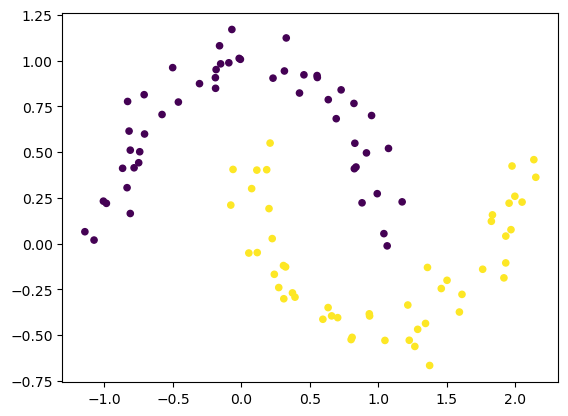

In [3]:
X, y = make_moons(n_samples=100, noise=0.1)

# y = 2.0 * y - 1.0

print(y.max(), y.min())

# visualize in 2D
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
y = np.expand_dims(y, 1)
print(X.shape, y.shape)

Label: Loss data 2.653699303892113, grad 1.0 op *


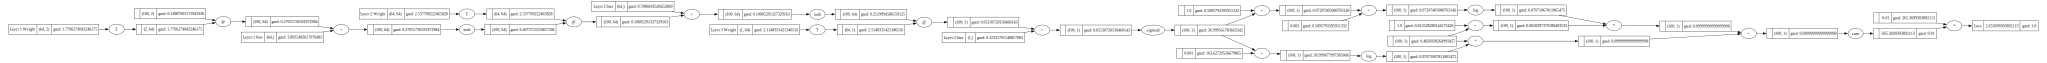

In [4]:

model = nn.Sequential(
    nn.Linear(2, 64, name="Layer 1"),
    nn.Tanh(),
    # nn.ReLU(),
    nn.Linear(64, 64, name="Layer 2"),
    nn.Tanh(),
    # nn.ReLU(),
    nn.Linear(64, 1, name="Layer 3"),
    nn.Sigmoid()
    # nn.Tanh()
    # nn.ReLU()
)

mse_loss_func = lambda y_true, y_pred: ((y_true - y_pred)**2).sum()

def bce_loss_func(y_true, y_pred):
    m = y_true.shape[0]
    t1 = y_true*((y_pred + 1.e-3).log())
    t2 = (1 - y_true)*((1 - y_pred + 1e-3).log())
    return (-1.0 / m) * (t1 + t2).sum()

def max_margin_loss_func(y_true, y_pred):
    m = y_true.shape[0]
    v = (1.0 - (y_pred * y_true)).relu()
    return (1.0 / m) * v.sum()

# print(X.shape)
loss = bce_loss_func(Tensor(y), model(Tensor(X)))
# loss = mse_loss_func(Tensor(y), model(Tensor(X)))
# loss = max_margin_loss_func(Tensor(y), model(Tensor(X)))
loss.label = "Loss"
loss.backward()
print(loss)
draw_dot(loss)

In [5]:
lr = 0.001
batch_size = 32
alpha = 1e-4
loss_hist = []
acc_hist = []

for k in range(1000):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    x_batch, y_batch = Tensor(X[ri, :]), Tensor(y[ri, :])
    model.zero_grad()
    y_pred = model(x_batch)
    # loss = max_margin_loss_func(y_batch, y_pred)
    loss = bce_loss_func(y_batch, y_pred)
    # loss = mse_loss_func(y_batch, y_pred)
    reg = alpha*sum((p*p).sum() for p in model.parameters())
    acc = np.sum((y_pred.data > 0.5) == y_batch.data) / y_batch.shape[0]
    # acc = np.sum((y_pred.data > 0) == (y_batch.data > 0)) / y_batch.shape[0]
    (loss + reg).backward()
    # (loss).backward()

    loss_hist.append(loss.data)
    acc_hist.append(acc)

    for p in model.parameters():
        # print(p.label, np.linalg.norm(p.grad))
        p.data -= lr*p.grad

    print(f"{k:03} loss: {loss.data}, acc: {acc*100}")

000 loss: 2.7904114425381237, acc: 46.875
001 loss: 3.3076176352836697, acc: 37.5
002 loss: 3.0457328128517647, acc: 40.625
003 loss: 2.310972721392795, acc: 56.25
004 loss: 2.5839203491304104, acc: 50.0
005 loss: 2.982978799775985, acc: 40.625
006 loss: 2.7501127420658227, acc: 43.75
007 loss: 2.4896232372872245, acc: 53.125
008 loss: 2.317799587040494, acc: 56.25
009 loss: 2.7766296042751604, acc: 46.875
010 loss: 2.8152676668561893, acc: 40.625
011 loss: 2.395214207299816, acc: 53.125
012 loss: 2.617496464493491, acc: 46.875
013 loss: 3.1484177260884962, acc: 37.5
014 loss: 2.3830660494961604, acc: 53.125
015 loss: 1.7581343385385375, acc: 68.75
016 loss: 2.6259555794073712, acc: 46.875
017 loss: 2.400498664608796, acc: 53.125
018 loss: 2.914652165458151, acc: 43.75
019 loss: 1.8429424034223985, acc: 56.25
020 loss: 2.4020427640372777, acc: 50.0
021 loss: 2.470707450501811, acc: 46.875
022 loss: 2.7993820957047078, acc: 43.75
023 loss: 2.75723670663961, acc: 50.0
024 loss: 2.2338529

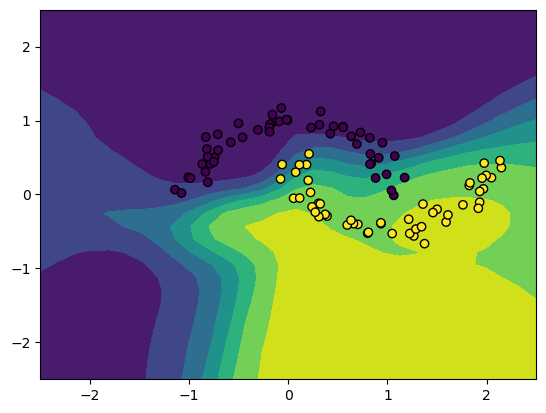

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay

xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 30), np.linspace(-2.5, 2.5, 30))
grid = np.vstack([xx.ravel(), yy.ravel()]).T
grid_tensor = Tensor(grid)
y_pred = model(grid_tensor)

display = DecisionBoundaryDisplay(xx0=xx, xx1=yy, response=np.reshape(y_pred.data, xx.shape))
display.plot()

display.ax_.scatter(
    X[:, 0], X[:, 1], c=y, edgecolor="black"
)

plt.show()

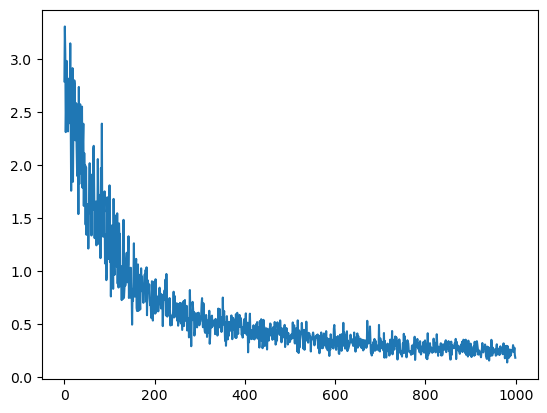

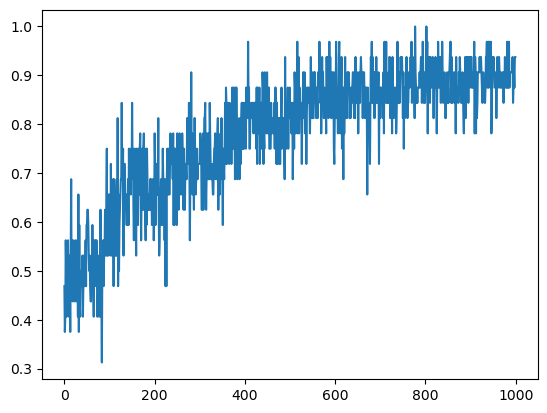

In [7]:
plt.plot(loss_hist)
plt.show()

plt.plot(acc_hist)
plt.show()